# Robustness of policies

In [140]:
# read in all the needed libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from ema_workbench.analysis import parcoords
from ema_workbench import (MultiprocessingEvaluator, Policy)
from ema_workbench.util import ema_logging

plt.rcParams['figure.figsize'] = [20, 10]

from problem_formulation import get_model_for_problem_formulation
dike_model, planning_steps = get_model_for_problem_formulation(3)

## Re-evaluate under deep uncertainty

Combine the pareto set of solutions found for each scenario. Next, turn each solution into a policy object. If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (*e.g.*, picking min and max on each objective, slicing across the pareto front with a particular step size). As a rule of thumb, try to limit the set of policies to at most 50. 

Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.


The results from the optimisation are read in. Only policies i.e. lever combinations are kept, that result in less than 0.01 expected deaths for A.5 Deventer. This ensures that all lever combinations that are considered for policies actually perform well over the worst case scenarios.

In [47]:
results = []
for i in range(5):
    results_scenario = pd.read_csv(f'outcomes/15k_results_optimisation_scenario{i}.csv')
    results_scenario = results_scenario[results_scenario['A.5_Expected Number of Deaths'] <= 1]
    results.append(results_scenario)

In [48]:
results[3].columns

Index(['Unnamed: 0', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1',
       '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1',
       '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
       'A.2_Expected Number of Deaths', 'A.3 Total Costs',
       'A.3_Expected Number of Deaths', 'A.4 Total Costs',
       'A.4_Expected Number of Deaths', 'A.5 Total Costs',
       'A.5_Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs'],
      dtype='object')

Following, the results for the 4 other dike rings (non-Deventer) are added up. This is due to the comparison between Deventer and the rest. Results for dike ring 4 (Gorssel) are kept to be able to directly compare Deventer's results to those of its neighbour Gorssel.

In [49]:
for i in range(len(results)):
    results[i]['Other Areas Total Number of Deaths'] = 0  
    results[i]['Other Areas Total Costs'] = 0
    results[i]['Scenario number'] = i
    
    for area in range(1,5):
        results[i]['Other Areas Total Number of Deaths'] += results[i][f'A.{area}_Expected Number of Deaths']
        results[i]['Other Areas Total Costs'] += results[i][f'A.{area} Total Costs']
    
    results[i] = results[i].drop(['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
       'A.2_Expected Number of Deaths', 'A.3 Total Costs',
       'A.3_Expected Number of Deaths', 'Unnamed: 0'], axis=1)

In [50]:
combined_results = results[0].append([results[1], results[2], results[3], results[4]], ignore_index=True)

From the 5 scenarios that were put into the optimisation (see notebook multi-scenario MORDM.ipynb), the maximum i.e. worst values for each of those scenarios for each column as well as the minimum i.e. best outcomes for those 5 optimised scenarios are taken. Then, the experiments matching those outcomes are are stored. 

In [51]:
outcomes_array = ['A.4 Total Costs', 
                  'A.4_Expected Number of Deaths',
                  'A.5 Total Costs',
                  'A.5_Expected Number of Deaths', 
                  'RfR Total Costs',
                  'Expected Evacuation Costs',
                  'Other Areas Total Number of Deaths',
                  'Other Areas Total Costs']


lever_array = outcomes_array + ['Scenario number']

result_best_worst_scenarios = []
for i in range(len(results)):
    result_best_worst = []
    result_worst = results[i].loc[results[i][outcomes_array].idxmax()]

    result_best = results[i].loc[results[i][outcomes_array].idxmin()]

    result_best_worst = result_best.append(result_worst)
    
    result_best_worst = result_best_worst.drop(lever_array, axis=1)
    result_best_worst_scenarios.append(result_best_worst)

In [52]:
len(result_best_worst_scenarios)

5

In [53]:
result_best_worst_all = result_best_worst_scenarios[0].append([result_best_worst_scenarios[1], result_best_worst_scenarios[2], result_best_worst_scenarios[3], result_best_worst_scenarios[4]], ignore_index=True)
result_best_worst_all

0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0         0        0        1        0        0        1        0        1   
1         0        0        1        0        0        0        0        0   
2         0        1        0        0        0        0        0        0   
3         0        0        1        0        0        0        0        0   
4         0        0        0        0        0        0        0        0   
..      ...      ...      ...      ...      ...      ...      ...      ...   
75        0        0        0        0        0        0        1        1   
76        1        1        1        1        0        1        1        1   
77        0        0        0        0        0        0        1        1   
78        0        0        1        0        0        0        1        0   
79        1        0        0        0        0        0        1        0   

    2_RfR 2  3_RfR 0  ...  A.2_DikeIncrease 2  A.3_DikeIncrease 0  \
0         0        1  ...                   4                   3   
1         1        1  ...                   3                   0   
2         0        1  ...                   1                   0   
3         1        1  ...                   3                   0   
4         0        0  ...                   5                   5   
..      ...      ...  ...                 ...                 ...   
75        0        0  ...                   0                   5   
76        1        1  ...                   2                   4   
77        1        0  ...                   3                   1   
78        0        0  ...                   2                   0   
79        0        0  ...                   6                   5   

    A.3_DikeIncrease 1  A.3_DikeIncrease 2  A.4_DikeIncrease 0  \
0                    0                   5                   3   
1                    0                   0                   4   
2                    0                   0                   4   
3                    0                   0                   4   
4                    0                   4                   6   
..                 ...                 ...                 ...   
75                   3                   0                   4   
76                   1                   7                   2   
77                   1                   3                   4   
78                   0                   1                   6   
79                   5                   9                   1   

    A.4_DikeIncrease 1  A.4_DikeIncrease 2  A.5_DikeIncrease 0  \
0                    0                   0                   1   
1                    0                   4                  10   
2                    6                   6                   7   
3                    0                   4                  10   
4                    1                   3                   6   
..                 ...                 ...                 ...   
75                   0                   1                   1   
76                   0                   0                   7   
77                   0                   4                   0   
78                   0                   0                   9   
79                   1                   7                  10   

    A.5_DikeIncrease 1  A.5_DikeIncrease 2  
0                    4                   3  
1                    1                   5  
2                    0                   0  
3                    1                   5  
4                    2                   6  
..                 ...                 ...  
75                   2                   1  
76                   3                   6  
77                   2                   0  
78                   2                   2  
79                   7                   1  

[80 rows x 31 columns]

It results, that some experiments are the same. Duplicates will be removed. Then, out of those experiments policies are created. 

In [54]:
duplicateDFRow = result_best_worst_all[result_best_worst_all.duplicated()]
result_best_worst_all_no_duplicates = result_best_worst_all.drop(duplicateDFRow.index)

In [55]:
result_best_worst_all_no_duplicates

0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
0         0        0        1        0        0        1        0        1   
1         0        0        1        0        0        0        0        0   
2         0        1        0        0        0        0        0        0   
4         0        0        0        0        0        0        0        0   
5         0        1        1        0        0        0        1        0   
..      ...      ...      ...      ...      ...      ...      ...      ...   
74        0        0        0        0        0        0        1        1   
75        0        0        0        0        0        0        1        1   
76        1        1        1        1        0        1        1        1   
78        0        0        1        0        0        0        1        0   
79        1        0        0        0        0        0        1        0   

    2_RfR 2  3_RfR 0  ...  A.2_DikeIncrease 2  A.3_DikeIncrease 0  \
0         0        1  ...                   4                   3   
1         1        1  ...                   3                   0   
2         0        1  ...                   1                   0   
4         0        0  ...                   5                   5   
5         0        1  ...                   5                   1   
..      ...      ...  ...                 ...                 ...   
74        1        0  ...                   3                   1   
75        0        0  ...                   0                   5   
76        1        1  ...                   2                   4   
78        0        0  ...                   2                   0   
79        0        0  ...                   6                   5   

    A.3_DikeIncrease 1  A.3_DikeIncrease 2  A.4_DikeIncrease 0  \
0                    0                   5                   3   
1                    0                   0                   4   
2                    0                   0                   4   
4                    0                   4                   6   
5                    6                   0                   4   
..                 ...                 ...                 ...   
74                   1                   3                   4   
75                   3                   0                   4   
76                   1                   7                   2   
78                   0                   1                   6   
79                   5                   9                   1   

    A.4_DikeIncrease 1  A.4_DikeIncrease 2  A.5_DikeIncrease 0  \
0                    0                   0                   1   
1                    0                   4                  10   
2                    6                   6                   7   
4                    1                   3                   6   
5                    2                   0                   7   
..                 ...                 ...                 ...   
74                   0                   4                   0   
75                   0                   1                   1   
76                   0                   0                   7   
78                   0                   0                   9   
79                   1                   7                  10   

    A.5_DikeIncrease 1  A.5_DikeIncrease 2  
0                    4                   3  
1                    1                   5  
2                    0                   0  
4                    2                   6  
5                    0                   5  
..                 ...                 ...  
74                   2                   0  
75                   2                   1  
76                   3                   6  
78                   2                   2  
79                   7                   1  

[66 rows x 31 columns]

In [56]:
policies = []
for j, row in result_best_worst_all_no_duplicates.iterrows():
        policy = Policy(f'scenario option {j}', **row.to_dict())
        policies.append(policy)

These policies represent the policies that perform best and worst over the worst-case scenarios but still meet the set threshold of 0.01 deaths in Deventer. 1000 scenarios are run with these policies to explore each policy's robustness.

In [15]:

ema_logging.log_to_stderr(level='INFO')


with MultiprocessingEvaluator(dike_model) as evaluator:
    reeevaluation_results = evaluator.perform_experiments(1000, policies=policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 66 policies * 1 model(s) = 66000 experiments
[MainProcess/INFO] 6600 cases completed
[MainProcess/INFO] 13200 cases completed
[MainProcess/INFO] 19800 cases completed
[MainProcess/INFO] 26400 cases completed
[MainProcess/INFO] 33000 cases completed
[MainProcess/INFO] 39600 cases completed
[MainProcess/INFO] 46200 cases completed
[MainProcess/INFO] 52800 cases completed
[MainProcess/INFO] 59400 cases completed
[MainProcess/INFO] 66000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [16]:
experiments = reeevaluation_results[0]
results = pd.DataFrame(reeevaluation_results[1])

In [17]:
results.to_csv('./outcomes/reevaluation_promising_policies_results.csv')
experiments.to_csv('./outcomes/reevaluation_promising_experiments.csv')


# Analysis
In this section, first the results from the previous run are read in. Then, the policies will be evaluated considering robustness. The robustness metrics Maximin and Minimax regret will be used. 

In [2]:
# read in results
results_load = pd.read_csv('./outcomes/reevaluation_promising_policies_results.csv')
experiments_load = pd.read_csv('./outcomes/reevaluation_promising_experiments.csv')

In [3]:
# adapt dataframes slightly: combine A.1 to A.4 for comparison reasons, 
# delete no longer needed columns (A.1 to A.3, A.4 kept for direct comparison)
results_load['Other Areas Total Number of Deaths'] = 0  
results_load['Other Areas Total Costs'] = 0

for area in range(1,5):
    results_load['Other Areas Total Number of Deaths'] += results_load[f'A.{area}_Expected Number of Deaths']
    results_load['Other Areas Total Costs'] += results_load[f'A.{area} Total Costs']

results_load = results_load.drop(['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
   'A.2_Expected Number of Deaths', 'A.3 Total Costs',
   'A.3_Expected Number of Deaths', 'Unnamed: 0'], axis=1)

In [4]:
experiments_load['A.5_total_dike_increase'] = 0

for time_step in range(3):
    experiments_load['A.5_total_dike_increase'] += experiments_load[f'A.5_DikeIncrease {time_step}']
experiments_load.head()

Unnamed: 0  A.0_ID flood wave shape    A.1_Bmax  A.1_Brate  A.1_pfail  \
0           0                    108.0  306.204867       10.0   0.200822   
1           1                     71.0  232.607582        1.5   0.155764   
2           2                     21.0  348.831088        1.0   0.196232   
3           3                      9.0  189.760125       10.0   0.339976   
4           4                    115.0  217.057027        1.5   0.826048   

     A.2_Bmax  A.2_Brate  A.2_pfail    A.3_Bmax  A.3_Brate  ...  \
0  162.325922        1.5   0.791249  210.485682       10.0  ...   
1   90.103364       10.0   0.987325  111.572437       10.0  ...   
2  265.196139       10.0   0.288037  185.085407       10.0  ...   
3  204.933490        1.5   0.925791  199.394990       10.0  ...   
4  290.177029        1.0   0.493298  128.670483        1.5  ...   

   A.4_DikeIncrease 0  A.4_DikeIncrease 1  A.4_DikeIncrease 2  \
0                 3.0                 0.0                 0.0   
1                 3.0                 0.0                 0.0   
2                 3.0                 0.0                 0.0   
3                 3.0                 0.0                 0.0   
4                 3.0                 0.0                 0.0   

   A.5_DikeIncrease 0  A.5_DikeIncrease 1  A.5_DikeIncrease 2  scenario  \
0                 1.0                 4.0                 3.0         0   
1                 1.0                 4.0                 3.0         1   
2                 1.0                 4.0                 3.0         2   
3                 1.0                 4.0                 3.0         3   
4                 1.0                 4.0                 3.0         4   

              policy     model  A.5_total_dike_increase  
0  scenario option 0  dikesnet                      8.0  
1  scenario option 0  dikesnet                      8.0  
2  scenario option 0  dikesnet                      8.0  
3  scenario option 0  dikesnet                      8.0  
4  scenario option 0  dikesnet                      8.0  

[5 rows x 55 columns]

In [5]:
# rename the policys from 'scenario option xx' to 'policy xx'
experiments_load['policy'] = experiments_load['policy'].str.replace('scenario option', 'Policy')

In [6]:
outcomes_array = ['A.4 Total Costs', 
                  'A.4_Expected Number of Deaths',
                  'A.5 Total Costs',
                  'A.5_Expected Number of Deaths', 
                  'RfR Total Costs',
                  'Expected Evacuation Costs',
                  'Other Areas Total Number of Deaths',
                  'Other Areas Total Costs', 'A.5_total_dike_increase']


lever_array = outcomes_array + ['Scenario number']

#### Functions for the further use

In [7]:
# function to find which outcomes are dominated by others,
# takes in the policy outcomes, gives back the index of those that are dominated i.e. that can be dropped later

def dominate(policy_outcomes):
    
    todrop = []
    for i in range(len(policy_outcomes)):
        for j in range(len(policy_outcomes)):
            if j == i:
                pass
            else: # if all values of one policy greater than those of others
                dominated = policy_outcomes.iloc[i,:] >= policy_outcomes.iloc[j,:]
                if dominated.sum() == len(policy_outcomes.columns):
                    todrop.append(i)
    return np.unique(todrop)

In [8]:
# function to create a parallel axis plot and save the figure
# takes in dataframe with outcomes of policies (the dominated one, so not as many to plot)
# gives out plot and saves figure to figures-folder

def axes_paraplot(dominate_policy, pref, name_figure):
    
    policy_names = pref.index.values[dominate_policy.index.values] # for legend
    
    limits = parcoords.get_limits(dominate_policy)
    axes = parcoords.ParallelAxes(limits)
    dominate_policy = dominate_policy.reset_index(drop=True)
    for i in range(len(dominate_policy)):   
        axes.plot(dominate_policy.iloc[i], label=policy_names[i], color=sns.color_palette('hls', len(dominate_policy))[i])
    axes.legend()

    plt.savefig(f'./figures/{name_figure}.png', bbox_inches="tight")
    return policy_names

### Maximin
Maximin is taking into account the worst case scenario the worst thing that could happen.

"the maximin metric has a very high level of intrinsic risk aversion, as its calculation is only based on the worst performance over all scenarios considered (Table 3), leading to a very conservative solution (Bertsimas & Sim, 2004). Similarly, the minimax regret metric assumes that the selected decision alternative will have the largest regret possible, as its calculation is based on the worst-case relative performance" https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017EF000649


In [21]:
policy_outcomes_maximin = results_load
policy_outcomes_maximin['policy'] = experiments_load['policy'] 
policy_outcomes_maximin['scenario'] = experiments_load['scenario'] 
policy_outcomes_maximin['A.5_total_dike_increase'] = experiments_load['A.5_total_dike_increase'] 

least_pref = pd.DataFrame()
for outcome in outcomes_array:
    least_pref[outcome] = policy_outcomes_maximin.groupby(['policy']).max()[outcome]


In [10]:
short_names = ['A.4_TC', 'A.4_Deaths', 'A.5_TC', 'A.5_Deaths', 'RfR Costs', 'Evac C', 'OTD', 'OTC', 'A.5Dike']
least_pref = least_pref.set_axis(short_names, axis=1)
least_pref = least_pref.reindex(columns = ['A.4_Deaths', 'A.5_Deaths', 'OTD', 'A.4_TC', 'A.5_TC', 'OTC', 'RfR Costs', 'Evac C', 'A.5Dike'])
least_pref = least_pref[least_pref['A.4_Deaths']<= 0.04]

x_maximin = least_pref.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_maximin_scaled = min_max_scaler.fit_transform(x_maximin)
least_pref_norm = pd.DataFrame(x_maximin_scaled)


least_pref_norm = least_pref_norm.set_axis(short_names, axis=1)
least_pref_norm = least_pref_norm.reindex(columns = ['A.4_Deaths', 'A.5_Deaths', 'OTD', 'A.4_TC', 'A.5_TC', 'OTC', 'RfR Costs', 'Evac C', 'A.5Dike'])


In [11]:
least_pref

A.4_Deaths  A.5_Deaths       OTD        A.4_TC        A.5_TC  \
policy                                                                    
Policy 0     0.009499    0.090317  0.618976  7.997940e+07  4.325901e+08   
Policy 1     0.002639    0.000000  0.271024  8.408985e+07  1.462890e+08   
Policy 10    0.008613    0.119143  0.394269  1.565935e+08  1.167809e+09   
Policy 12    0.002646    0.016587  0.081714  7.546212e+07  3.381949e+08   
Policy 14    0.007118    0.000000  2.730960  8.273445e+07  9.043017e+07   
Policy 17    0.000349    0.058525  0.865871  6.989008e+07  1.817528e+08   
Policy 18    0.007417    0.069689  0.227708  1.796668e+08  6.813717e+08   
Policy 2     0.000824    0.003003  0.367948  6.407926e+07  7.136096e+07   
Policy 20    0.001160    0.115641  2.221542  7.630234e+07  2.370023e+08   
Policy 22    0.003113    0.023149  0.013214  7.671932e+07  2.649006e+08   
Policy 23    0.029820    0.031151  2.050079  1.048254e+08  1.120228e+08   
Policy 24    0.000113    0.001318  0.002432  8.592097e+07  1.291789e+08   
Policy 26    0.002509    0.101369  0.253279  9.840501e+07  1.217381e+09   
Policy 28    0.000000    0.005767  0.736458  5.332187e+07  9.414394e+07   
Policy 29    0.007419    0.097879  0.335929  1.808952e+08  1.202423e+09   
Policy 32    0.010696    0.000000  0.736314  8.601087e+07  1.488336e+08   
Policy 33    0.002460    0.002170  0.122248  5.160653e+07  9.055225e+07   
Policy 35    0.005873    0.000000  0.657710  3.446027e+07  1.294640e+08   
Policy 36    0.017045    0.117135  2.216869  8.751132e+07  2.627497e+08   
Policy 39    0.013251    0.003802  0.619653  9.575928e+07  1.366154e+08   
Policy 4     0.024638    0.166140  2.698331  9.527713e+07  3.748584e+08   
Policy 40    0.007700    0.001754  0.168649  1.883768e+08  1.778408e+08   
Policy 42    0.004888    0.098992  0.281405  1.048161e+08  1.117576e+09   
Policy 43    0.000000    0.747072  3.246252  4.146268e+07  9.856642e+08   
Policy 47    0.004788    0.000000  0.165721  9.807523e+07  8.122223e+07   
Policy 48    0.032882    0.000000  2.481067  9.525437e+07  1.266629e+08   
Policy 49    0.003220    0.000000  0.495136  8.203596e+07  9.827666e+07   
Policy 5     0.023622    0.017398  1.309766  7.501247e+07  1.087245e+08   
Policy 50    0.007155    0.008650  2.169331  4.466755e+07  5.775419e+07   
Policy 52    0.005902    0.003672  0.365886  1.252670e+08  1.693893e+08   
Policy 53    0.003813    0.000000  0.782471  4.060712e+07  9.676792e+07   
Policy 55    0.020186    0.061199  1.835999  6.095957e+07  1.662184e+08   
Policy 56    0.023027    0.101646  1.162329  1.817706e+08  3.899148e+08   
Policy 58    0.008572    0.129259  0.311992  1.362457e+08  1.122657e+09   
Policy 60    0.001140    0.000436  0.248583  5.637142e+07  1.647162e+08   
Policy 61    0.006196    0.095571  0.298231  1.496984e+08  1.059443e+09   
Policy 63    0.036530    0.019716  2.619289  1.079397e+08  8.205123e+07   
Policy 64    0.003387    0.002990  0.092731  7.428029e+07  1.259784e+08   
Policy 65    0.003634    0.027760  0.075174  8.968347e+07  3.185971e+08   
Policy 66    0.013914    0.003788  0.427184  1.250982e+08  6.276655e+07   
Policy 68    0.002472    0.030427  0.369656  1.048142e+08  4.890968e+08   
Policy 69    0.006866    0.008699  1.777275  5.465159e+07  8.712306e+07   
Policy 7     0.018693    0.426800  3.034771  8.772745e+07  5.314958e+08   
Policy 70    0.001656    0.000000  0.240552  5.383558e+07  9.043017e+07   
Policy 71    0.011035    0.012840  0.579882  1.060399e+08  1.199100e+08   
Policy 74    0.005827    0.100810  0.267058  1.384150e+08  1.105764e+09   
Policy 76    0.003166    0.002461  0.054460  8.466587e+07  1.577375e+08   
Policy 78    0.032331    0.012449  2.471402  8.804259e+07  1.415077e+08   
Policy 79    0.017480    0.001819  0.276015  1.544331e+08  1.687970e+08   
Policy 8     0.009533    0.024463  0.190551  1.882738e+08  2.606681e+08   

                    OTC     RfR Costs         Evac C  A.5Dike  
policy                                        

In [12]:
least_pref_norm_45 = least_pref_norm[['A.4_Deaths', 'A.5_Deaths',  'A.4_TC', 'A.5_TC', 'A.5Dike']]
least_pref_norm_others5 = least_pref_norm[['A.5_Deaths', 'OTD', 'A.5_TC',  'OTC', 'RfR Costs', 'Evac C','A.5Dike']]

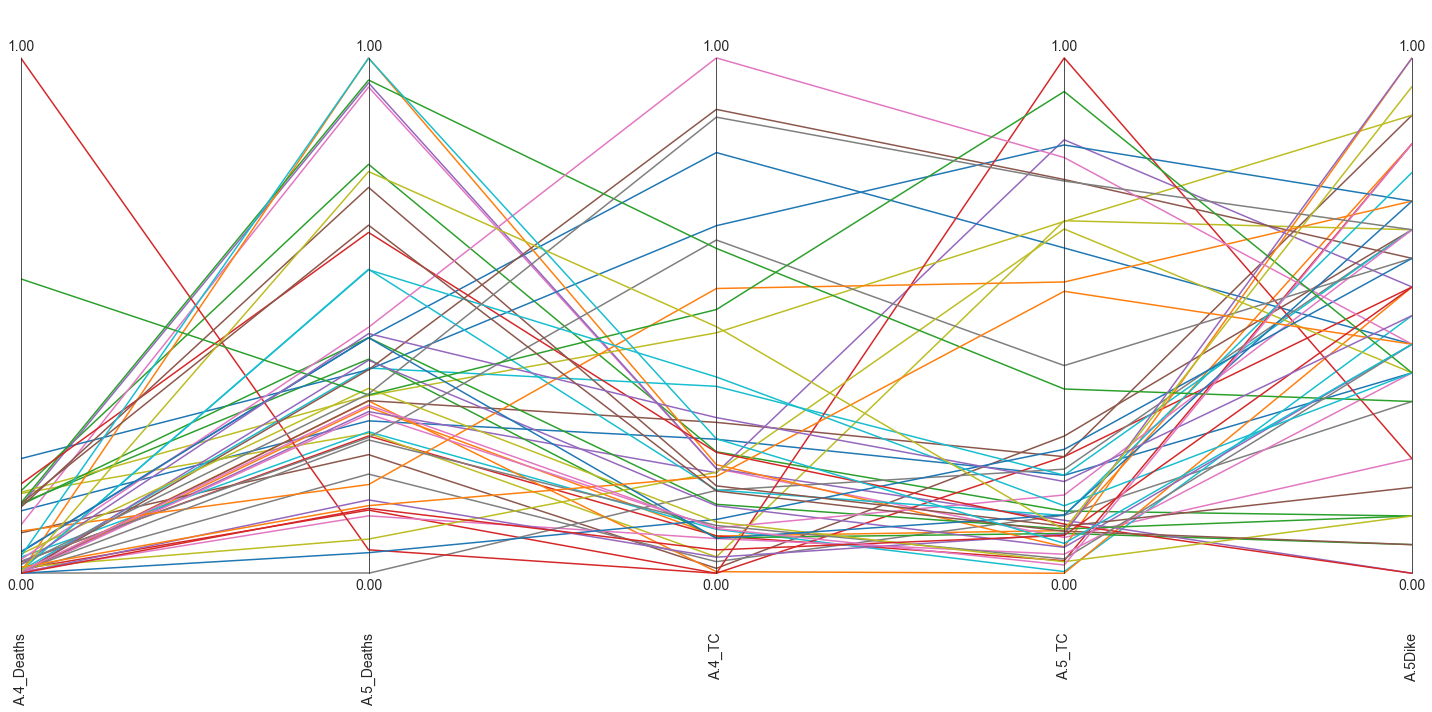

In [141]:
limits = parcoords.get_limits(least_pref_norm_45)
axes = parcoords.ParallelAxes(limits)
axes.plot(least_pref_norm_45)
plt.savefig('./figures/maximin_norm_45_undominated.png')

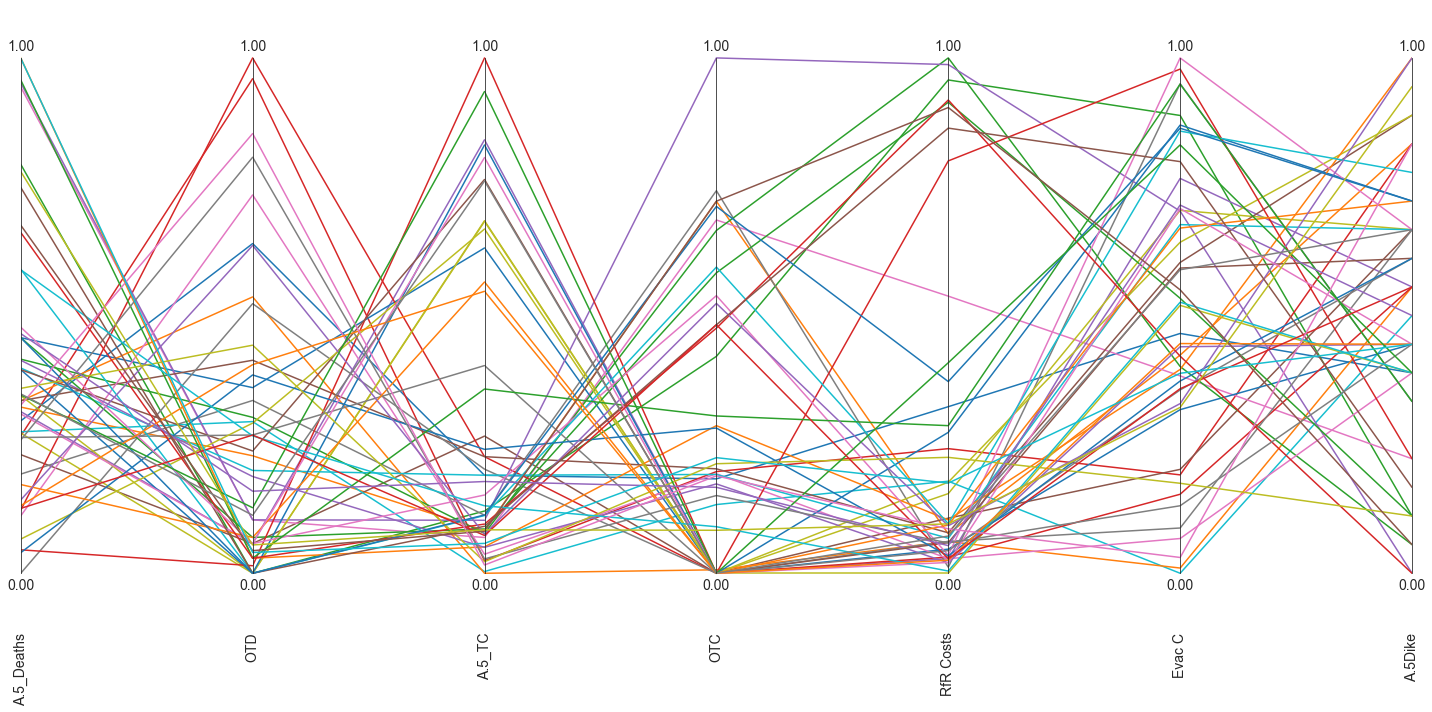

In [142]:
limits = parcoords.get_limits(least_pref_norm_others5)
axes = parcoords.ParallelAxes(limits)
axes.plot(least_pref_norm_others5)
plt.savefig('./figures/maximin_norm_others5_undominated.png')

In [15]:
least_pref_norm_45_dominate = least_pref_norm_45.drop(dominate(least_pref_norm_45))
least_pref_norm_others5_dominate = least_pref_norm_others5.drop(dominate(least_pref_norm_others5))

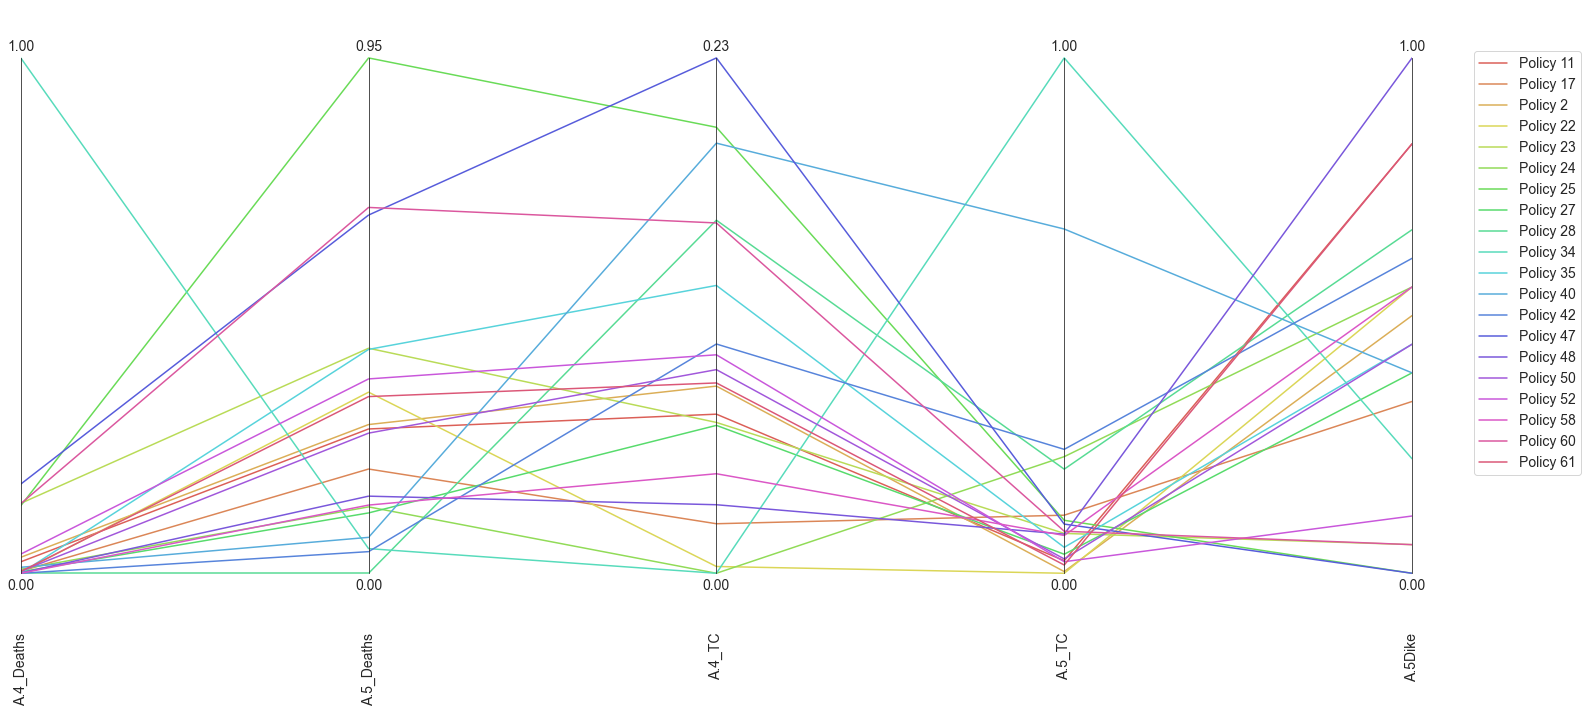

In [143]:
policies_maximin_45 = axes_paraplot(least_pref_norm_45_dominate, least_pref, 'maximin_norm_45_dominated')

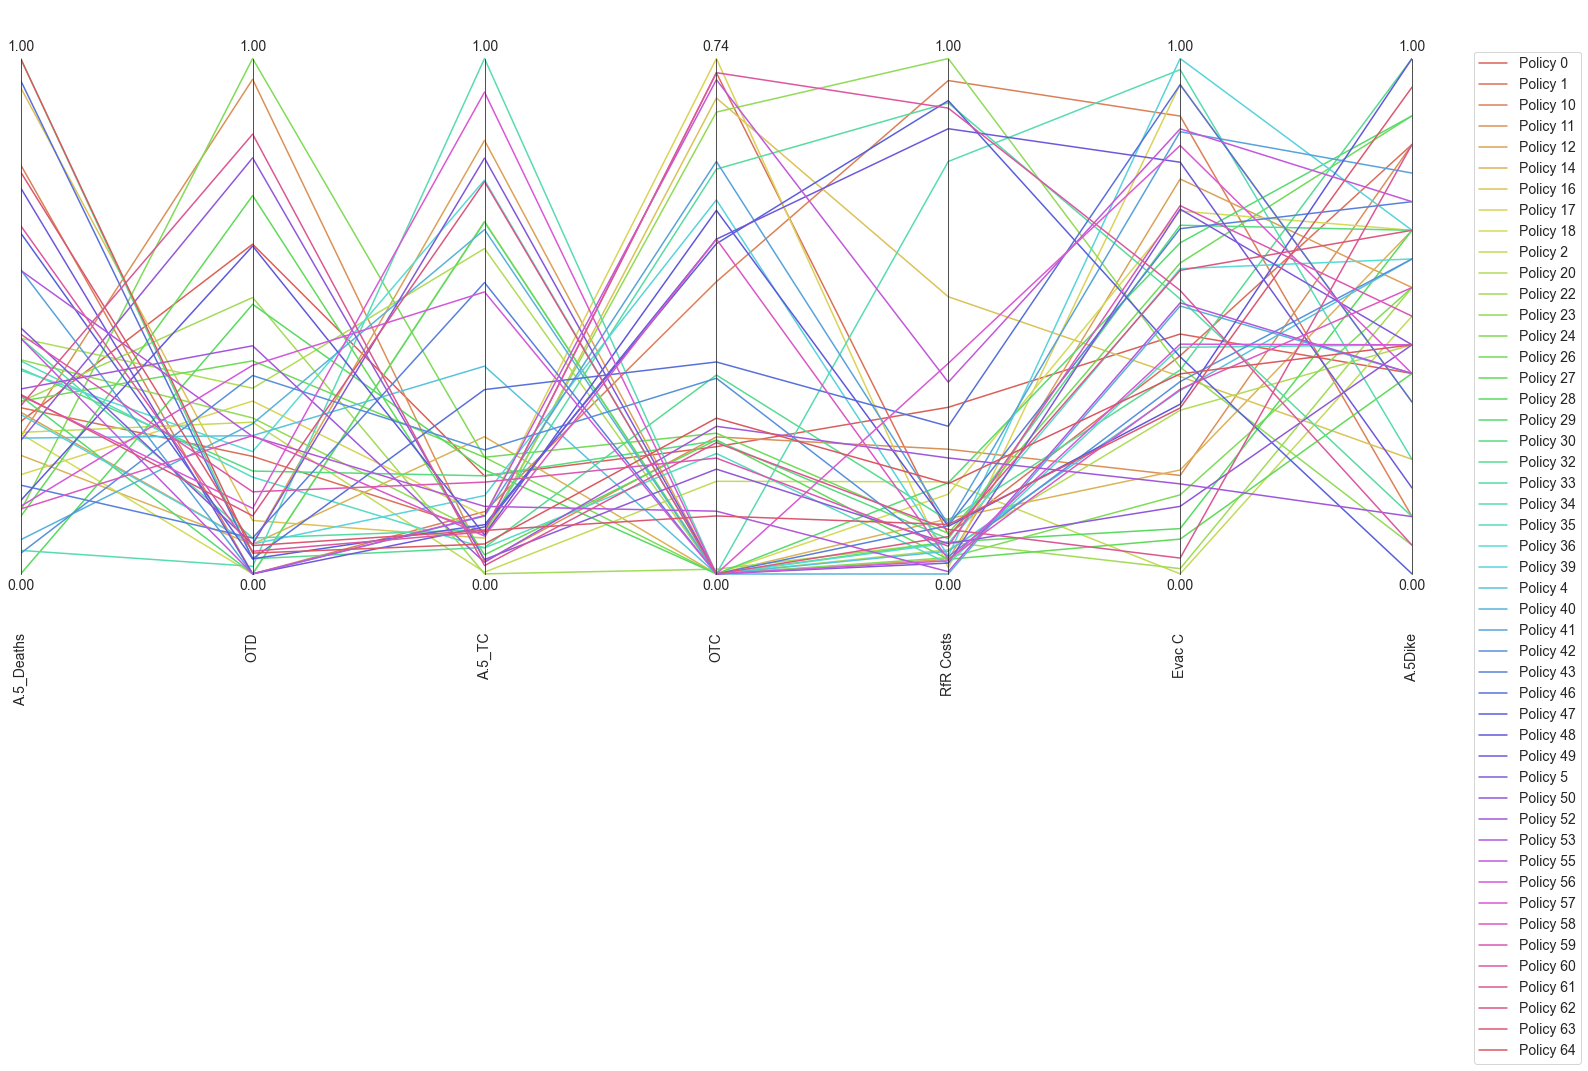

In [144]:
policies_maximin_others5 = axes_paraplot(least_pref_norm_others5_dominate, least_pref, 'maximin_norm_others5_dominated')

In [19]:
policies_maximin_others5

array(['Policy 0', 'Policy 1', 'Policy 10', 'Policy 12', 'Policy 14',
       'Policy 17', 'Policy 18', 'Policy 2', 'Policy 20', 'Policy 22',
       'Policy 23', 'Policy 24', 'Policy 26', 'Policy 28', 'Policy 32',
       'Policy 33', 'Policy 35', 'Policy 36', 'Policy 39', 'Policy 40',
       'Policy 42', 'Policy 43', 'Policy 47', 'Policy 48', 'Policy 49',
       'Policy 5', 'Policy 50', 'Policy 52', 'Policy 53', 'Policy 55',
       'Policy 56', 'Policy 58', 'Policy 60', 'Policy 61', 'Policy 63',
       'Policy 64', 'Policy 65', 'Policy 66', 'Policy 68', 'Policy 69',
       'Policy 7', 'Policy 70', 'Policy 71', 'Policy 74', 'Policy 76',
       'Policy 78', 'Policy 79', 'Policy 8'], dtype=object)

In [20]:
policies_maximin_45

array(['Policy 12', 'Policy 2', 'Policy 22', 'Policy 24', 'Policy 26',
       'Policy 28', 'Policy 29', 'Policy 33', 'Policy 35', 'Policy 43',
       'Policy 47', 'Policy 50', 'Policy 53', 'Policy 58', 'Policy 60',
       'Policy 64', 'Policy 65', 'Policy 70', 'Policy 74', 'Policy 76'],
      dtype=object)

### Minimax Regret Criterion
The Minimax Regret Criterion is a technique used to make decisions under uncertainty. The context of a decision making process under uncertainty, a decision maker is faced to uncertain states of nature and a number of decision alternatives that can be chosen. The decision made and the final state of nature (which the decision maker does not know beforehand) determines the payoff.

Under this Minimax Regret Criterion, the decision maker calculates the maximum opportunity loss values (or also known as regret) for each alternative, and then she chooses the decision that has the lowest maximum regret.

The regret or opportunity loss for a specific alternative, at a given state of nature, is how much we lose by choosing that alternative and not the optimal alternative, given that state of nature (if the current alternative IS the optima alternative, then the opportunity loss for that alternative, given the state of nature, is 0).

https://mathcracker.com/minimax-regret-criterion-calculator

In [36]:
policy_outcomes = results_load
policy_outcomes_regret = results_load.copy()
# add scenario and policy to dataframe
policy_outcomes_regret['scenario'] = experiments_load['scenario']
policy_outcomes_regret['policy'] = experiments_load['policy']


most_pref = pd.DataFrame()
for outcome in outcomes_array:
    most_pref[outcome] = policy_outcomes_regret.groupby(['policy']).min()[outcome] 

most_pref.reset_index(inplace=True)
#most_pref = most_pref.drop('scenario', axis=1)

In [37]:
most_pref

policy  A.4 Total Costs  A.4_Expected Number of Deaths  \
0    Policy 0     8.453408e+06                            0.0   
1    Policy 1     2.078505e+07                            0.0   
2   Policy 10     1.692524e+07                            0.0   
3   Policy 11     1.106877e+07                            0.0   
4   Policy 12     7.332080e+06                            0.0   
..        ...              ...                            ...   
61  Policy 76     7.332080e+06                            0.0   
62  Policy 78     1.258646e+07                            0.0   
63  Policy 79     2.811056e+07                            0.0   
64   Policy 8     7.332080e+06                            0.0   
65   Policy 9     6.320800e+06                            0.0   

    A.5 Total Costs  A.5_Expected Number of Deaths  RfR Total Costs  \
0      9.545879e+07                            0.0     1.343800e+09   
1      1.462890e+08                            0.0     4.789000e+08   
2      7.770751e+07                            0.0     0.000000e+00   
3      7.074086e+07                            0.0     0.000000e+00   
4      1.341380e+08                            0.0     2.015900e+09   
..              ...                            ...              ...   
61     1.389496e+08                            0.0     1.792200e+09   
62     1.303402e+08                            0.0     2.365000e+08   
63     1.643440e+08                            0.0     1.153000e+08   
64     7.908444e+07                            0.0     8.460000e+07   
65     8.454688e+07                            0.0     1.460000e+08   

    Expected Evacuation Costs  Other Areas Total Number of Deaths  \
0                    0.000000                                 0.0   
1                    0.000000                                 0.0   
2                  141.914208                                 0.0   
3                    0.000000                                 0.0   
4                    0.000000                                 0.0   
..                        ...                                 ...   
61                   0.000000                                 0.0   
62                   0.000000                                 0.0   
63                   0.000000                                 0.0   
64                   0.000000                                 0.0   
65                   0.000000                                 0.0   

    Other Areas Total Costs  A.5_total_dike_increase  
0              4.063320e+08                      8.0  
1              2.127035e+08                     16.0  
2              3.840111e+08                      3.0  
3              2.484557e+08                      8.0  
4              6.902568e+08                     16.0  
..                      ...                      ...  
61             2.762047e+08                     16.0  
62             2.036767e+08                     13.0  
63             4.911282e+08                     18.0  
64             2.497830e+08                      9.0  
65             2.892480e+08                     10.0  

[66 rows x 10 columns]

In [38]:
policy_outcomes_regret

A.4 Total Costs  A.4_Expected Number of Deaths  A.5 Total Costs  \
0         8.453408e+06                       0.000000     1.004570e+08   
1         8.453408e+06                       0.000000     9.545879e+07   
2         8.453408e+06                       0.000000     1.192903e+08   
3         8.453408e+06                       0.000000     9.905568e+07   
4         8.453408e+06                       0.000000     9.545879e+07   
...                ...                            ...              ...   
65995     2.896907e+07                       0.000132     1.643440e+08   
65996     3.282399e+07                       0.001286     1.643440e+08   
65997     3.286032e+07                       0.001214     1.643440e+08   
65998     2.866368e+07                       0.000142     1.643440e+08   
65999     2.811056e+07                       0.000000     1.643440e+08   

       A.5_Expected Number of Deaths  RfR Total Costs  \
0                           0.001221     1.343800e+09   
1                           0.000000     1.343800e+09   
2                           0.011230     1.343800e+09   
3                           0.001133     1.343800e+09   
4                           0.000000     1.343800e+09   
...                              ...              ...   
65995                       0.000000     1.153000e+08   
65996                       0.000000     1.153000e+08   
65997                       0.000000     1.153000e+08   
65998                       0.000000     1.153000e+08   
65999                       0.000000     1.153000e+08   

       Expected Evacuation Costs  Other Areas Total Number of Deaths  \
0                     115.624205                            0.000000   
1                      24.535732                            0.001007   
2                    1135.063294                            0.000000   
3                     108.468194                            0.000000   
4                       0.000000                            0.000000   
...                          ...                                 ...   
65995                  19.925985                            0.000132   
65996                 238.674855                            0.001286   
65997                 197.857654                            0.001214   
65998                  20.395824                            0.000142   
65999                 375.215983                            0.004770   

       Other Areas Total Costs     policy  scenario  A.5_total_dike_increase  
0                 4.063320e+08   Policy 0         0                      8.0  
1                 4.092804e+08   Policy 0         1                      8.0  
2                 4.063320e+08   Policy 0         2                      8.0  
3                 4.063320e+08   Policy 0         3                      8.0  
4                 4.063320e+08   Policy 0         4                      8.0  
...                        ...        ...       ...                      ...  
65995             4.919867e+08  Policy 79       995                     18.0  
65996             4.958416e+08  Policy 79       996                     18.0  
65997             4.958779e+08  Policy 79       997                     18.0  
65998             4.916813e+08  Policy 79       998                     18.0  
65999             5.027407e+08  Policy 79       999                     18.0  

[66000 rows x 11 columns]

In [123]:
for i in range(len(policy_outcomes_regret)):
    for j in range(len(most_pref)):
        if policy_outcomes_regret['policy'][i] == most_pref['policy'][j]:
            for outcome in outcomes_array:
                policy_outcomes_regret[outcome][i] -= most_pref[outcome][j]

<ipython-input-123-f1c685773121>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  policy_outcomes_regret[outcome][i] -= most_pref[outcome][j]


In [124]:
policy_outcomes_regret.to_csv('./outcomes/minimax_regret_outcomes.csv')

In [39]:
policy_outcomes_regret = pd.read_csv('./outcomes/minimax_regret_outcomes.csv')

In [40]:
worst_regret = policy_outcomes_regret.groupby('policy').max().drop(['scenario', 'Unnamed: 0', 'A.5_total_dike_increase'], axis=1)
worst_regret

A.4 Total Costs  A.4_Expected Number of Deaths  A.5 Total Costs  \
policy                                                                       
Policy 0      7.152599e+07                       0.009499     3.371313e+08   
Policy 1      6.330480e+07                       0.002639     0.000000e+00   
Policy 10     1.396683e+08                       0.008613     1.090102e+09   
Policy 11     1.208078e+08                       0.052106     7.092075e+08   
Policy 12     6.813004e+07                       0.002646     2.040568e+08   
...                    ...                            ...              ...   
Policy 76     7.733379e+07                       0.003166     1.878788e+07   
Policy 78     7.545613e+07                       0.032331     1.116753e+07   
Policy 79     1.263225e+08                       0.017480     4.452985e+06   
Policy 8      1.809418e+08                       0.009533     1.815837e+08   
Policy 9      1.816341e+08                       0.064424     5.041310e+07   

           A.5_Expected Number of Deaths  RfR Total Costs  \
policy                                                      
Policy 0                        0.090317              0.0   
Policy 1                        0.000000              0.0   
Policy 10                       0.119143              0.0   
Policy 11                       0.590559              0.0   
Policy 12                       0.016587              0.0   
...                                  ...              ...   
Policy 76                       0.002461              0.0   
Policy 78                       0.012449              0.0   
Policy 79                       0.001819              0.0   
Policy 8                        0.024463              0.0   
Policy 9                        0.051876              0.0   

           Expected Evacuation Costs  Other Areas Total Number of Deaths  \
policy                                                                     
Policy 0                24455.544144                            0.618976   
Policy 1                96364.291453                            0.271024   
Policy 10               56048.372531                            0.394269   
Policy 11                   0.000000                            3.314296   
Policy 12               26339.311622                            0.081714   
...                              ...                                 ...   
Policy 76               25231.714596                            0.054460   
Policy 78                   0.000000                            2.471402   
Policy 79               11136.968644                            0.276015   
Policy 8                29948.459602                            0.190551   
Policy 9                    0.000000                            2.339688   

           Other Areas Total Costs  
policy                              
Policy 0              1.651230e+09  
Policy 1              1.720411e+09  
Policy 10             2.925395e+09  
Policy 11             3.357398e+09  
Policy 12             5.551981e+08  
...                            ...  
Policy 76             4.948089e+08  
Policy 78             2.219754e+09  
Policy 79             1.141757e+09  
Policy 8              1.579146e+09  
Policy 9              2.047989e+09  

[66 rows x 8 columns]

In [41]:
short_names = ['A.4_TC', 'A.4_Deaths', 'A.5_TC', 'A.5_Deaths', 'RfR Costs', 'Evac C', 'OTD', 'OTC']

worst_regret = worst_regret.set_axis(short_names, axis=1)
worst_regret = worst_regret.reindex(columns = ['A.4_Deaths', 'A.5_Deaths', 'OTD', 'A.4_TC', 'A.5_TC', 'OTC', 'RfR Costs', 'Evac C'])


x_minimax = worst_regret.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_minimax_scaled = min_max_scaler.fit_transform(x_minimax)
worst_regret_norm = pd.DataFrame(x_minimax_scaled)


worst_regret_norm = worst_regret_norm.set_axis(short_names, axis=1)
worst_regret_norm = worst_regret_norm.reindex(columns = ['A.4_Deaths', 'A.5_Deaths', 'OTD', 'A.4_TC', 'A.5_TC', 'OTC', 'RfR Costs', 'Evac C'])

In [42]:
worst_regret_norm_45 = worst_regret_norm[['A.4_Deaths', 'A.5_Deaths',  'A.4_TC', 'A.5_TC']]
worst_regret_norm_others5 = worst_regret_norm[['A.5_Deaths', 'OTD', 'A.5_TC',  'OTC', 'RfR Costs', 'Evac C']]

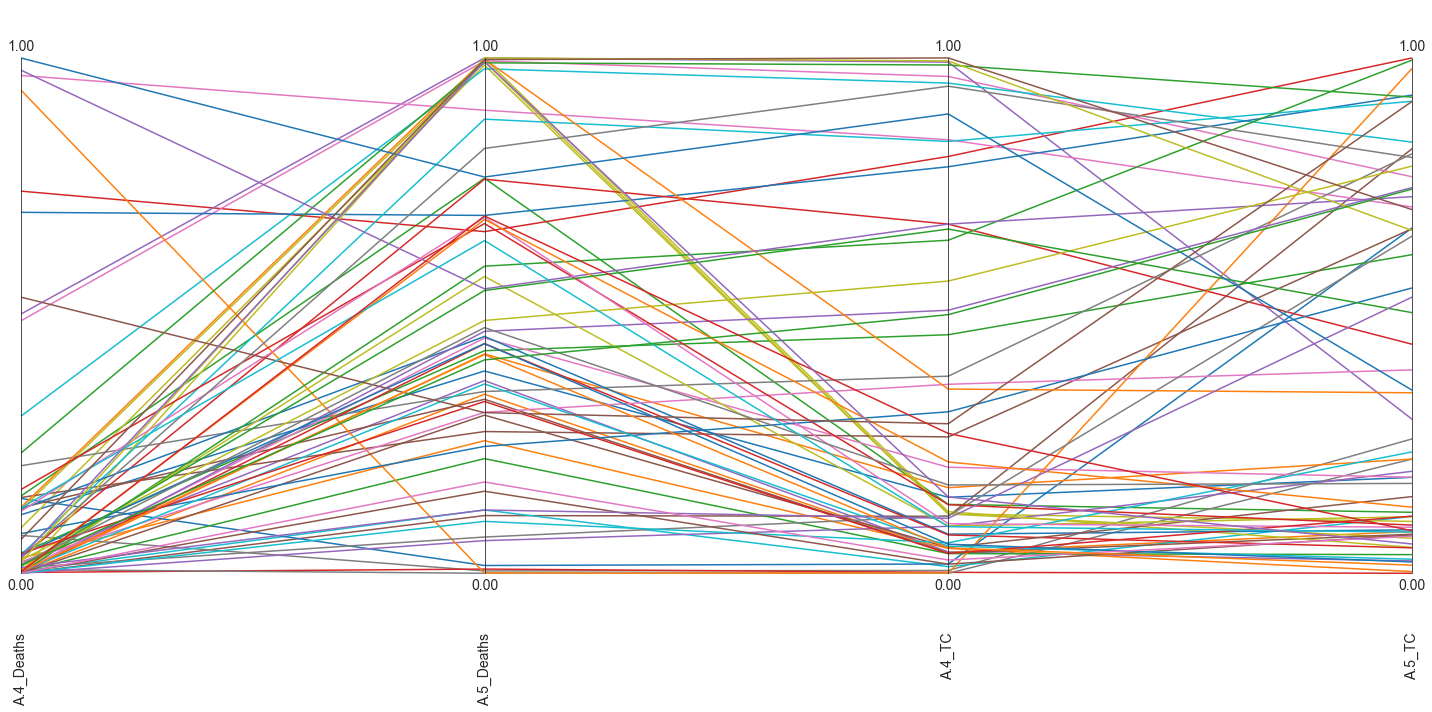

In [145]:
limits = parcoords.get_limits(worst_regret_norm_45)
axes = parcoords.ParallelAxes(limits)
axes.plot(worst_regret_norm_45)
plt.savefig('./figures/minimax_norm_45_undominated.png')

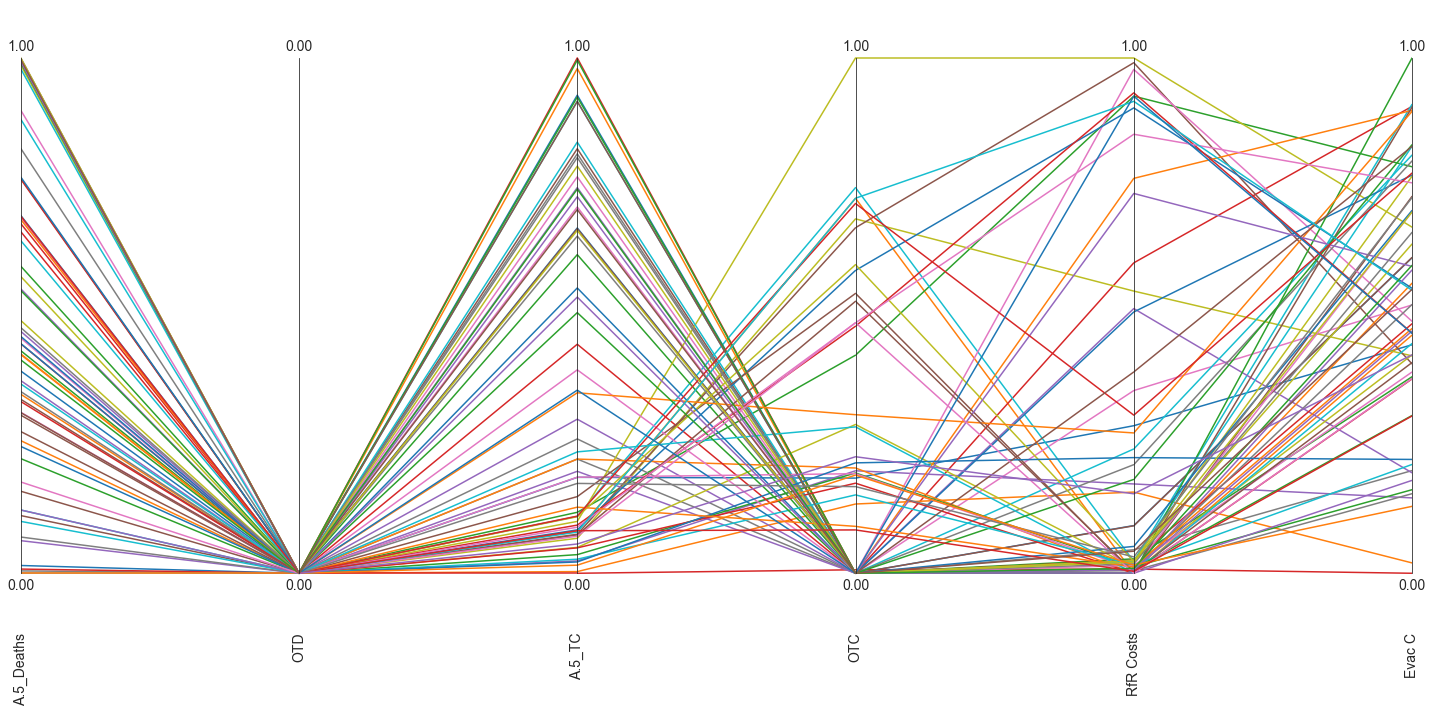

In [146]:
limits = parcoords.get_limits(worst_regret_norm_others5)
axes = parcoords.ParallelAxes(limits)
axes.plot(worst_regret_norm_others5)
plt.savefig('./figures/minimax_norm_others5_undominated.png')

In [45]:
worst_regret_norm_45_dominate = worst_regret_norm_45.drop(dominate(worst_regret_norm_45))
worst_regret_norm_others5_dominate = worst_regret_norm_others5.drop(dominate(worst_regret_norm_others5))

In [46]:
most_pref = most_pref.set_index('policy')

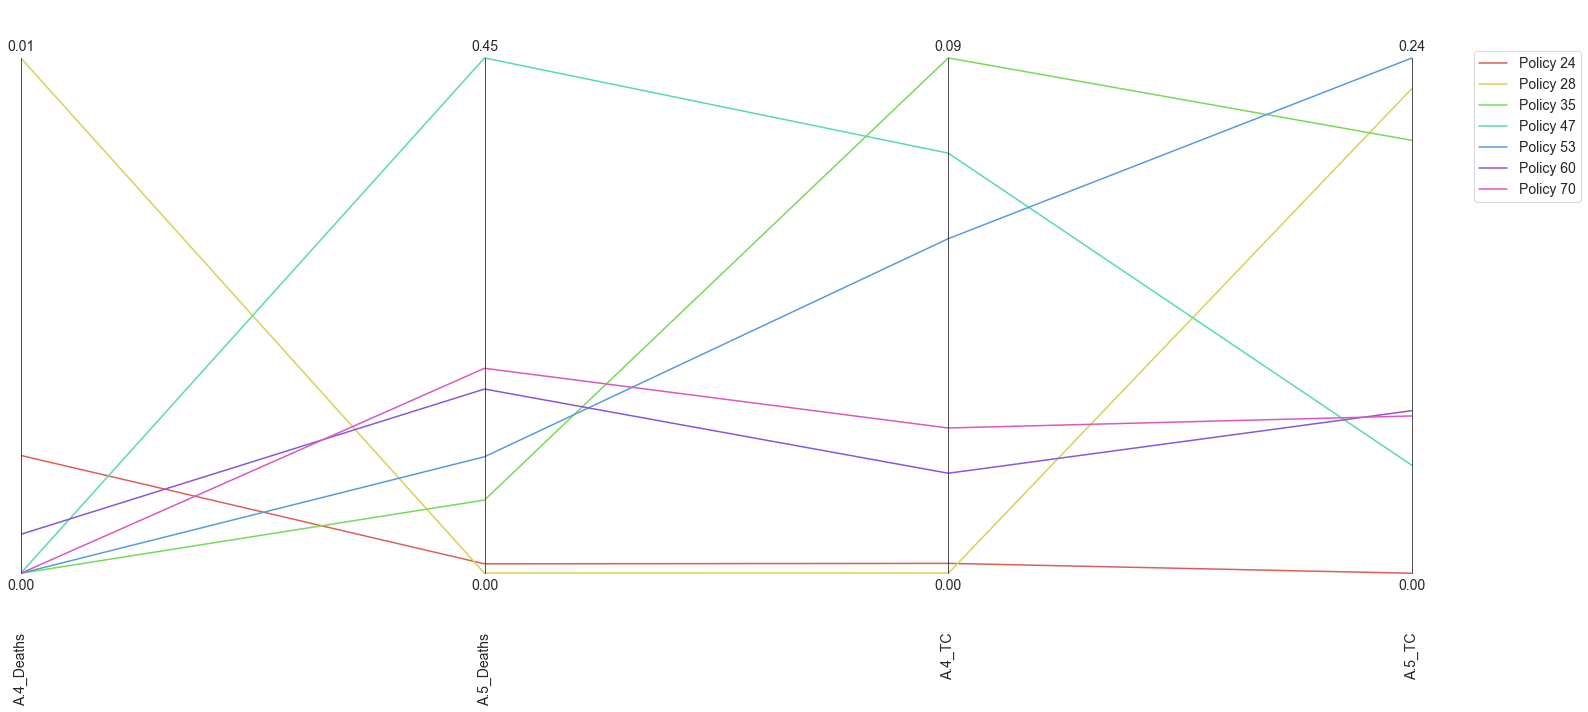

In [147]:
policies_minimax_45 = axes_paraplot(worst_regret_norm_45_dominate, most_pref, 'minimax_norm_45_dominated')

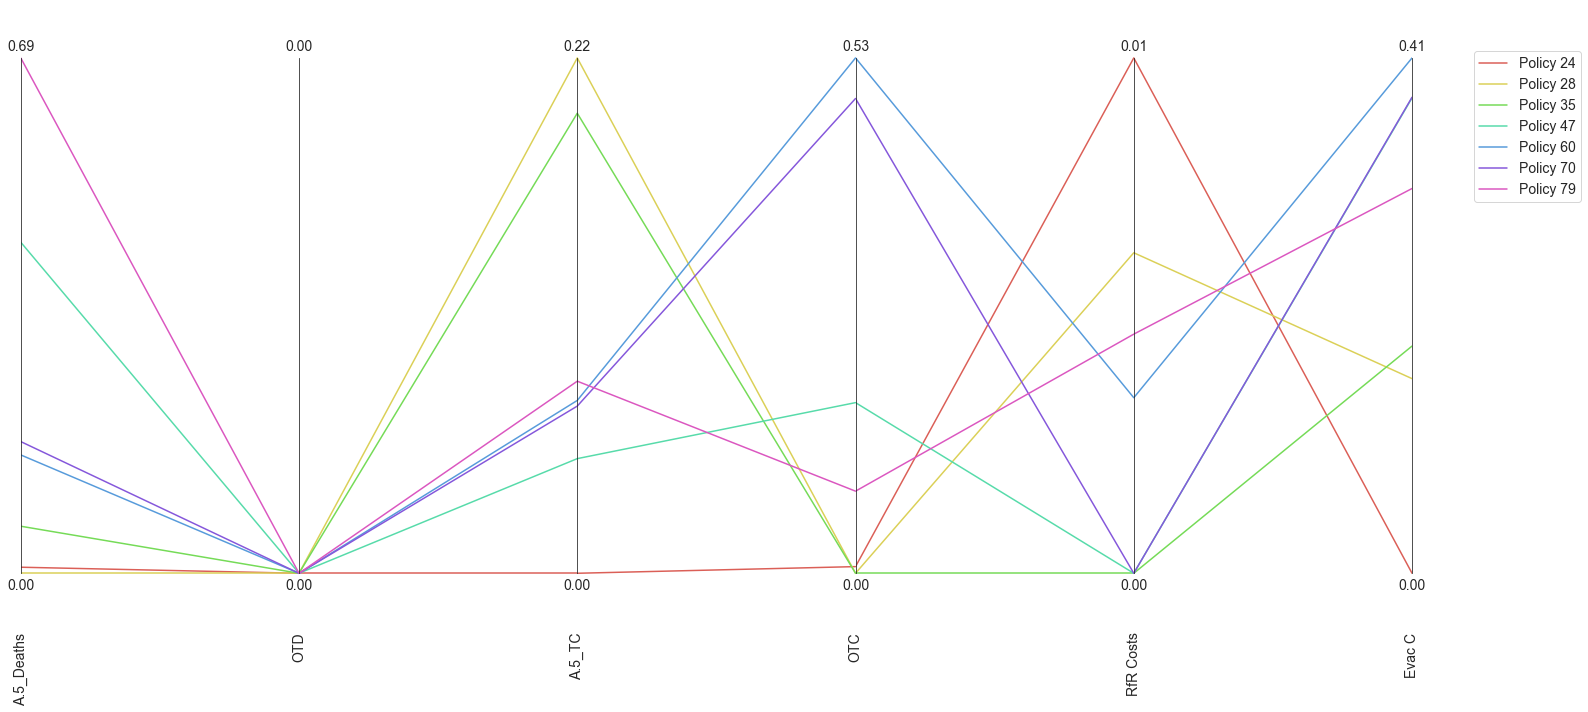

In [148]:
policies_minimax_others5 = axes_paraplot(worst_regret_norm_others5_dominate, most_pref, 'minimax_norm_others5_dominated')

In [49]:
policies_minimax_45

array(['Policy 24', 'Policy 28', 'Policy 35', 'Policy 47', 'Policy 53',
       'Policy 60', 'Policy 70'], dtype=object)

In [50]:
policies_minimax_others5

array(['Policy 24', 'Policy 28', 'Policy 35', 'Policy 47', 'Policy 60',
       'Policy 70', 'Policy 79'], dtype=object)

#### Table with all the policies

In [73]:
policies_levers = experiments_load.groupby('policy').min()
policies_levers = policies_levers[['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1',
       '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1',
       '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2']]
policies_levers.to_csv('./outcomes/all_policies.csv')

In [72]:
# check if policies with no dike increase in Deventer
no_dike5_increase = policies_levers[(policies_levers['A.5_DikeIncrease 0'] == 0) & (policies_levers['A.5_DikeIncrease 1'] == 0)
                                    & (policies_levers['A.5_DikeIncrease 2'] == 0)]
no_dike5_increase

Empty DataFrame
Columns: [0_RfR 0, 0_RfR 1, 0_RfR 2, 1_RfR 0, 1_RfR 1, 1_RfR 2, 2_RfR 0, 2_RfR 1, 2_RfR 2, 3_RfR 0, 3_RfR 1, 3_RfR 2, 4_RfR 0, 4_RfR 1, 4_RfR 2, EWS_DaysToThreat, A.1_DikeIncrease 0, A.1_DikeIncrease 1, A.1_DikeIncrease 2, A.2_DikeIncrease 0, A.2_DikeIncrease 1, A.2_DikeIncrease 2, A.3_DikeIncrease 0, A.3_DikeIncrease 1, A.3_DikeIncrease 2, A.4_DikeIncrease 0, A.4_DikeIncrease 1, A.4_DikeIncrease 2, A.5_DikeIncrease 0, A.5_DikeIncrease 1, A.5_DikeIncrease 2]
Index: []

[0 rows x 31 columns]

### Find common policies in maximin and minimax regret

In [55]:
common_minimax_policies = []
for i in range(len(policies_minimax_45)):
    for j in range(len(policies_minimax_others5)):
        if policies_minimax_45[i] == policies_minimax_others5[j]:
            common_minimax_policies.append(policies_minimax_45[i])
common_minimax_policies

['Policy 24', 'Policy 28', 'Policy 35', 'Policy 47', 'Policy 60', 'Policy 70']

In [56]:
common_maximin_policies = []
for i in range(len(policies_maximin_45)):
    for j in range(len(policies_maximin_others5)):
        if policies_maximin_45[i] == policies_maximin_others5[j]:
            common_maximin_policies.append(policies_maximin_45[i])
common_maximin_policies

['Policy 12',
 'Policy 2',
 'Policy 22',
 'Policy 24',
 'Policy 26',
 'Policy 28',
 'Policy 33',
 'Policy 35',
 'Policy 43',
 'Policy 47',
 'Policy 50',
 'Policy 53',
 'Policy 58',
 'Policy 60',
 'Policy 64',
 'Policy 65',
 'Policy 70',
 'Policy 74',
 'Policy 76']

In [57]:
common_robustness_policies = []
for i in range(len(common_minimax_policies)):
    for j in range(len(common_maximin_policies)):
        if common_minimax_policies[i] == common_maximin_policies[j]:
            common_robustness_policies.append(common_minimax_policies[i])
common_robustness_policies

['Policy 24', 'Policy 28', 'Policy 35', 'Policy 47', 'Policy 60', 'Policy 70']

above policies undominated on both maximin and minimax regret
no other policies that perform better on both these robustness metrics for both rival problem formulations

### parallel axis plot of found policies vs rest

In [120]:
results_load

A.4 Total Costs  A.4_Expected Number of Deaths  A.5 Total Costs  \
0         8.453408e+06                       0.000000     1.004570e+08   
1         8.453408e+06                       0.000000     9.545879e+07   
2         8.453408e+06                       0.000000     1.192903e+08   
3         8.453408e+06                       0.000000     9.905568e+07   
4         8.453408e+06                       0.000000     9.545879e+07   
...                ...                            ...              ...   
65995     2.896907e+07                       0.000132     1.643440e+08   
65996     3.282399e+07                       0.001286     1.643440e+08   
65997     3.286032e+07                       0.001214     1.643440e+08   
65998     2.866368e+07                       0.000142     1.643440e+08   
65999     2.811056e+07                       0.000000     1.643440e+08   

       A.5_Expected Number of Deaths  RfR Total Costs  \
0                           0.001221     1.343800e+09   
1                           0.000000     1.343800e+09   
2                           0.011230     1.343800e+09   
3                           0.001133     1.343800e+09   
4                           0.000000     1.343800e+09   
...                              ...              ...   
65995                       0.000000     1.153000e+08   
65996                       0.000000     1.153000e+08   
65997                       0.000000     1.153000e+08   
65998                       0.000000     1.153000e+08   
65999                       0.000000     1.153000e+08   

       Expected Evacuation Costs  Other Areas Total Number of Deaths  \
0                     115.624205                                   0   
1                      24.535732                                   0   
2                    1135.063294                                   0   
3                     108.468194                                   0   
4                       0.000000                                   0   
...                          ...                                 ...   
65995                  19.925985                                   0   
65996                 238.674855                                   0   
65997                 197.857654                                   0   
65998                  20.395824                                   0   
65999                 375.215983                                   0   

       Other Areas Total Costs     policy  scenario  A.5_total_dike_increase  
0                            0   Policy 0         0                      8.0  
1                            0   Policy 0         1                      8.0  
2                            0   Policy 0         2                      8.0  
3                            0   Policy 0         3                      8.0  
4                            0   Policy 0         4                      8.0  
...                        ...        ...       ...                      ...  
65995                        0  Policy 79       995                     18.0  
65996                        0  Policy 79       996                     18.0  
65997                        0  Policy 79       997                     18.0  
65998                        0  Policy 79       998                     18.0  
65999                        0  Policy 79       999                     18.0  

[66000 rows x 11 columns]

In [121]:
results_policies_mean = results_load.groupby('policy').mean()
results_policies_mean = results_policies_mean.reset_index()
results_policies_mean

policy  A.4 Total Costs  A.4_Expected Number of Deaths  \
0    Policy 0     9.610063e+06                       0.000174   
1    Policy 1     2.136919e+07                       0.000030   
2   Policy 10     1.998171e+07                       0.000224   
3   Policy 11     1.296303e+07                       0.000915   
4   Policy 12     8.694861e+06                       0.000064   
..        ...              ...                            ...   
61  Policy 76     9.573665e+06                       0.000110   
62  Policy 78     1.308537e+07                       0.000241   
63  Policy 79     4.284273e+07                       0.002539   
64   Policy 8     3.743308e+07                       0.002130   
65   Policy 9     3.081054e+07                       0.011579   

    A.5 Total Costs  A.5_Expected Number of Deaths  RfR Total Costs  \
0      1.064395e+08                       0.003585     1.343800e+09   
1      1.462890e+08                       0.000000     4.789000e+08   
2      1.361835e+08                       0.007950     0.000000e+00   
3      1.224428e+08                       0.046797     0.000000e+00   
4      1.384927e+08                       0.000463     2.015900e+09   
..              ...                            ...              ...   
61     1.390015e+08                       0.000007     1.792200e+09   
62     1.303513e+08                       0.000012     2.365000e+08   
63     1.643520e+08                       0.000003     1.153000e+08   
64     8.022001e+07                       0.000147     8.460000e+07   
65     8.469014e+07                       0.000139     1.460000e+08   

    Expected Evacuation Costs  Other Areas Total Number of Deaths  \
0                 1077.310989                                 0.0   
1                13402.329710                                 0.0   
2                13484.850827                                 0.0   
3                    0.000000                                 0.0   
4                 1916.777293                                 0.0   
..                        ...                                 ...   
61                1592.325021                                 0.0   
62                   0.000000                                 0.0   
63                 816.931236                                 0.0   
64                4985.550637                                 0.0   
65                   0.000000                                 0.0   

    Other Areas Total Costs  scenario  A.5_total_dike_increase  
0                       0.0     499.5                      8.0  
1                       0.0     499.5                     16.0  
2                       0.0     499.5                      3.0  
3                       0.0     499.5                      8.0  
4                       0.0     499.5                     16.0  
..                      ...       ...                      ...  
61                      0.0     499.5                     16.0  
62                      0.0     499.5                     13.0  
63                      0.0     499.5                     18.0  
64                      0.0     499.5                      9.0  
65                      0.0     499.5                     10.0  

[66 rows x 11 columns]

In [122]:
results_policies_mean.loc[13, 'policy']

'Policy 24'

In [123]:
robust_policies_results = []

for i in range(len(results_policies_mean)):
    if results_policies_mean.loc[i, 'policy'] in common_robustness_policies:
        robust_policies_results.append(results_policies_mean.iloc[i])
    else:
        pass
robust_policies_results

[policy                                       Policy 24
 A.4 Total Costs                        84439855.362575
 A.4_Expected Number of Deaths                      0.0
 A.5 Total Costs                       119625748.930507
 A.5_Expected Number of Deaths                 0.000005
 RfR Total Costs                           1126400000.0
 Expected Evacuation Costs                     5.325871
 Other Areas Total Number of Deaths                 0.0
 Other Areas Total Costs                            0.0
 scenario                                         499.5
 A.5_total_dike_increase                           11.0
 Name: 13, dtype: object,
 policy                                      Policy 28
 A.4 Total Costs                       53321867.639595
 A.4_Expected Number of Deaths                     0.0
 A.5 Total Costs                       88181407.645539
 A.5_Expected Number of Deaths                0.000006
 RfR Total Costs                          2100500000.0
 Expected Evacuation Costs  

In [124]:
outcomes_array_policy = outcomes_array + ['policy']
outcomes_array_policy

['A.4 Total Costs',
 'A.4_Expected Number of Deaths',
 'A.5 Total Costs',
 'A.5_Expected Number of Deaths',
 'RfR Total Costs',
 'Expected Evacuation Costs',
 'Other Areas Total Number of Deaths',
 'Other Areas Total Costs',
 'A.5_total_dike_increase',
 'policy']

In [125]:
robust_policies_results_DF = pd.DataFrame(robust_policies_results, columns=outcomes_array)
robust_policies_results_DF

A.4 Total Costs  A.4_Expected Number of Deaths  A.5 Total Costs  \
13     8.443986e+07                   1.511502e-07     1.196257e+08   
17     5.332187e+07                   0.000000e+00     8.818141e+07   
24     2.297415e+07                   2.155079e-05     1.294640e+08   
33     2.172859e+07                   3.101994e-04     8.122223e+07   
45     2.762181e+07                   1.327971e-05     1.614505e+08   
56     2.172088e+07                   9.128186e-06     9.043017e+07   

    A.5_Expected Number of Deaths  RfR Total Costs  Expected Evacuation Costs  \
13                   5.337911e-06     1.126400e+09                   5.325871   
17                   5.766673e-06     2.100500e+09                   0.000000   
24                   0.000000e+00     1.098800e+09                   0.000000   
33                   0.000000e+00     3.943000e+08                1721.427482   
45                   4.356840e-07     1.336200e+09                6385.535460   
56                   0.000000e+00     5.635000e+08                2316.819576   

    Other Areas Total Number of Deaths  Other Areas Total Costs  \
13                                 0.0                      0.0   
17                                 0.0                      0.0   
24                                 0.0                      0.0   
33                                 0.0                      0.0   
45                                 0.0                      0.0   
56                                 0.0                      0.0   

    A.5_total_dike_increase  
13                     11.0  
17                     11.0  
24                     13.0  
33                      9.0  
45                     19.0  
56                     11.0

In [126]:
short_names_dike_increase = short_names + ['A.5_Dike']

In [127]:
robust_policies_results_DF = robust_policies_results_DF.set_axis(short_names_dike_increase, axis=1)
robust_policies_results_DF = robust_policies_results_DF.reindex(columns = ['A.4_Deaths', 'A.5_Deaths', 'OTD', 'A.4_TC', 'A.5_TC', 'OTC', 'RfR Costs', 'Evac C', 'A.5_Dike'])

In [129]:
results_policies_mean = results_policies_mean.drop(['scenario', 'policy'], axis = 1)
results_policies_mean = results_policies_mean.set_axis(short_names_dike_increase, axis=1)
results_policies_mean = results_policies_mean.reindex(columns = ['A.4_Deaths', 'A.5_Deaths', 'OTD', 'A.4_TC', 'A.5_TC', 'OTC', 'RfR Costs', 'Evac C', 'A.5_Dike'])

In [131]:
results_policies_mean

A.4_Deaths  A.5_Deaths  OTD        A.4_TC        A.5_TC  OTC  \
0     0.000174    0.003585  0.0  9.610063e+06  1.064395e+08  0.0   
1     0.000030    0.000000  0.0  2.136919e+07  1.462890e+08  0.0   
2     0.000224    0.007950  0.0  1.998171e+07  1.361835e+08  0.0   
3     0.000915    0.046797  0.0  1.296303e+07  1.224428e+08  0.0   
4     0.000064    0.000463  0.0  8.694861e+06  1.384927e+08  0.0   
..         ...         ...  ...           ...           ...  ...   
61    0.000110    0.000007  0.0  9.573665e+06  1.390015e+08  0.0   
62    0.000241    0.000012  0.0  1.308537e+07  1.303513e+08  0.0   
63    0.002539    0.000003  0.0  4.284273e+07  1.643520e+08  0.0   
64    0.002130    0.000147  0.0  3.743308e+07  8.022001e+07  0.0   
65    0.011579    0.000139  0.0  3.081054e+07  8.469014e+07  0.0   

       RfR Costs        Evac C  A.5_Dike  
0   1.343800e+09   1077.310989       8.0  
1   4.789000e+08  13402.329710      16.0  
2   0.000000e+00  13484.850827       3.0  
3   0.000000e+00      0.000000       8.0  
4   2.015900e+09   1916.777293      16.0  
..           ...           ...       ...  
61  1.792200e+09   1592.325021      16.0  
62  2.365000e+08      0.000000      13.0  
63  1.153000e+08    816.931236      18.0  
64  8.460000e+07   4985.550637       9.0  
65  1.460000e+08      0.000000      10.0  

[66 rows x 9 columns]

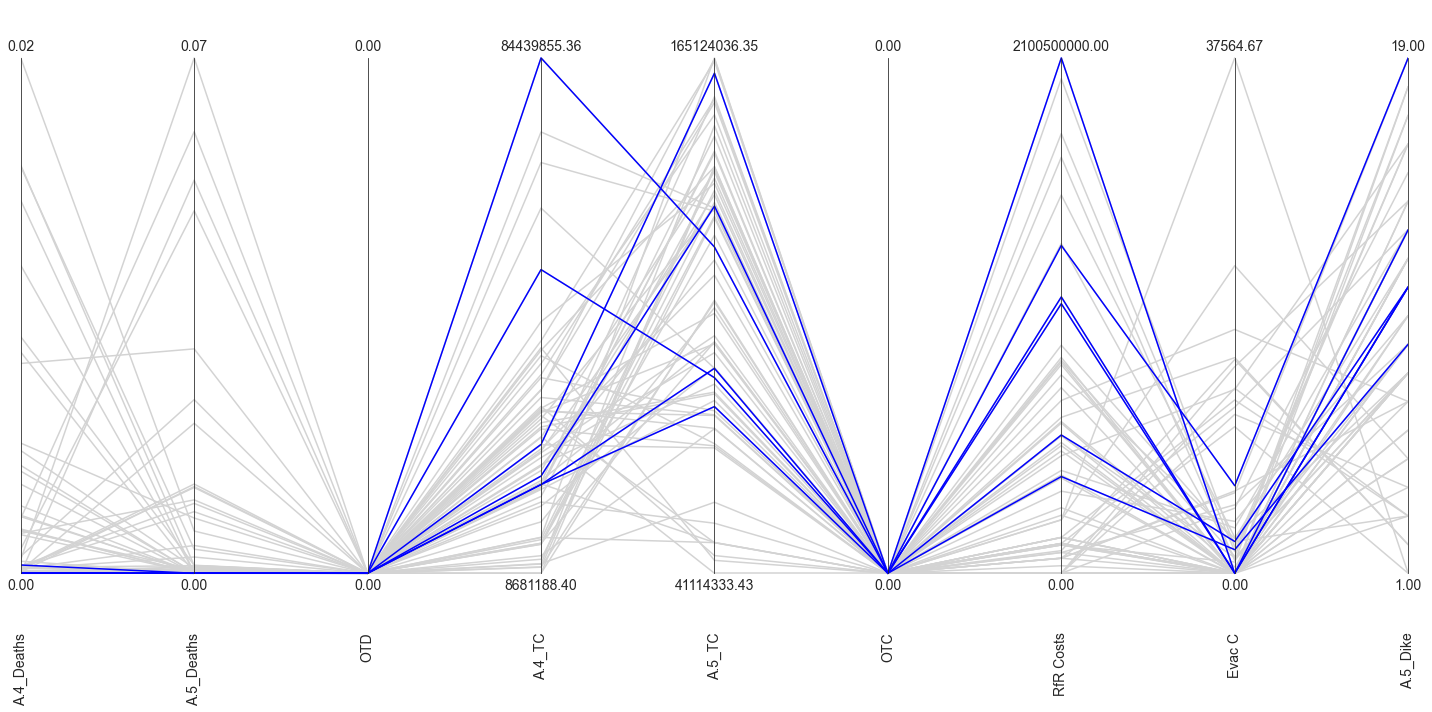

<Figure size 1440x720 with 0 Axes>

In [150]:
limits = parcoords.get_limits(results_policies_mean)
axes = parcoords.ParallelAxes(limits)

axes.plot(results_policies_mean, color='lightgrey', label = 'other policies')
axes.plot(robust_policies_results_DF, color='blue', label = 'robust policies')
plt.show()
plt.savefig('./outcomes/robust_policies_comparison_to_other_policies.png')